<a href="https://colab.research.google.com/github/Nyamadie/Loss-analysis/blob/main/Channels_Update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [1]:
! pip install dash emd -q plotly dash-bootstrap-components

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 16.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd ''

/content/drive/.shortcut-targets-by-id/1zgbI4HtAh4L5VsbEGVeF9fSUylAVhvLx/QFHD


In [4]:
from google.colab import files
uploaded = files.upload()

Saving patient_data (11).csv to patient_data (11) (7).csv


## Libraries

In [5]:
import pickle
import pandas as pd
import torch
import emd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import find_peaks
from qf_plus_shared.src.signal_processing import *
sys.path.append('')
import scipy.signal

# Data Preprocessing

In [6]:
patient_file_path = ''
pickle_file_path = ''
with open(pickle_file_path, 'rb') as file:
    signal_data = pickle.load(file)

df = pd.read_csv(patient_file_path)
filtered_df = df[df['Data QA'] >= 0.4].dropna(subset=['z_score'])
filenames = filtered_df['filenames'].tolist()

ppg_signals_df = signal_data['file_data']

# Extract signals corresponding to 10 filenames
selected_filenames = filenames[:30]
selected_signals = []
for filename in selected_filenames:
    if filename in ppg_signals_df:
        signal_data = ppg_signals_df[filename]

        # Check if both 'env_scaled' and 'filt_cycle' exist
        if 'env_scaled' in signal_data and 'filt_cycle' in signal_data:
            selected_signals.append(signal_data['env_scaled'].values)
        else:
            print(f"Missing 'env_scaled' or 'filt_cycle' in {filename}")
    else:
        print(f"File {filename} not found in PPG signals.")


# K's Peak Finder

In [7]:
def find_element_indexes(long_list, target_list):
  """
  Finds the indexes of elements in the target list within the long list.

  Args:
      long_list: A list containing elements.
      target_list: A list containing elements to search for.

  Returns:
      A list containing the indexes of the elements in the target list found in the long list.
  """
  results = []
  for element in target_list:
    try:
      # Use index() to find the first occurrence of the element
      index = long_list.index(element)
      results.append(index)
    except ValueError:
      # Element not found, append None
      results.append(None)
  return results

def extract_cycles_peaks_troughs(
    imf: np.ndarray, all_cycles: np.ndarray
) -> Tuple[List[np.ndarray], List[float], List[float]]:
    import emd

    """
    Extract cycles, peaks, and troughs from the best IMF.

    Args:
        imf (numpy.ndarray): IMF data.
        all_cycles (numpy.ndarray): Cycle data.

    Returns:
        tuple: Lists of cycles, peaks, and troughs.
    """
    ctrl = emd.cycles.get_control_points(imf[:, 0], all_cycles[:, 0])
    ncycles = len(ctrl)
    cycles, peaks, troughs, peak_values, valley_values = [], [], [], [], []

    for ii in range(ncycles):
        cycle = imf[all_cycles[:, 0] == ii, 0]
        for jj in range(5):
            if np.isfinite(ctrl[ii, jj]):
                if jj == 1:
                    peaks.append(ctrl[ii, jj])
                    peak_values.append(cycle[int(ctrl[ii, jj])])  # Access peak value
                if jj == 3:
                    troughs.append(ctrl[ii, jj])
                    valley_values.append(cycle[int(ctrl[ii, jj])])  # Access valley value
        cycles.append(cycle)

    return cycles, peaks, troughs, peak_values, valley_values

def bob_cycles_gen(peaks, valleys):
    """
    Finds cycles based on peaks and valleys.

    Args:
        peaks (numpy.ndarray): Array of peak values.
        valleys (numpy.ndarray): Array of valley values.

    Returns:
        numpy.ndarray: Array of cycles, where each cycle is represented as [start_valley, first_peak, NaN, end_valley].
    """
    if peaks.size > 1 and valleys.size > 1:
        cycles = []
        avg_period = np.mean(np.concatenate((np.diff(peaks), np.diff(valleys))))
        for val_idx in range(len(valleys) - 1):
            rel_dist = (valleys[val_idx + 1] - valleys[val_idx]) / avg_period
            if 0.33 <= rel_dist <= 2.00:
                peaks_btwn = peaks[(peaks > valleys[val_idx]) & (peaks < valleys[val_idx + 1])]
                if len(peaks_btwn) > 0:
                    cycles.append([valleys[val_idx], peaks_btwn[0], np.nan, valleys[val_idx + 1]])
    elif peaks.size == 1 and valleys.size == 0:
        cycles = [[np.nan, peaks[0], np.nan, np.nan]]
    elif valleys.size == 1 and peaks.size == 0:
        cycles = [[valleys[0], np.nan, np.nan, np.nan]]
    elif peaks.size == 1 and valleys.size == 1:
        if valleys[0] < peaks[0]:
            cycles = [[valleys[0], peaks[0], np.nan, np.nan]]
        else:
            cycles = [[np.nan, peaks[0], np.nan, valleys[0]]]
    else:
        cycles = np.empty((0, 4))

    return np.array(cycles)

# Resampling

In [8]:
def process_signals(ppg_signals_df, selected_filenames, target_length=50):
    stretched_signals = {}  # Channel 1
    stretching_factors = {}  # Channel 2
    subtracted_signals = {}
    time_varying_stretching_factors = {} # Time based stretching factor
    peak_indices = {}  # store peak indices

    for filename in selected_filenames:
        if filename not in ppg_signals_df:
            print(f"Warning: {filename} not found.")
            continue

        # First, process the filt_cycle data to detect peaks
        data = ppg_signals_df[filename]['filt_cycle']
        ppg = data.to_numpy()

        # Perform EMD processing
        imf, all_cycles = perform_emd(ppg)
        best_imf_idx = find_best_imf(imf, all_cycles)
        imf, all_cycles = sum_imfs(imf, all_cycles, best_imf_idx)
        all_cycles = recalculate_cycles(imf, len(ppg))
        cycles, peaks, troughs, peak_values, valley_values = extract_cycles_peaks_troughs(imf, all_cycles)

        imf_list = imf[:, 0].tolist()
        peaks_idx = find_element_indexes(imf_list, peak_values)
        valleys_idx = find_element_indexes(imf_list, valley_values)

        # Store peak indices for this file
        peak_indices[filename] = {
            'peaks': peaks_idx,
            'valleys': valleys_idx
        }

        # Generate Bob cycles
        bob_cycles = bob_cycles_gen(np.array(peaks_idx), np.array(valleys_idx))

        # Now use env_scaled for actual segmentation
        data1 = ppg_signals_df[filename]['env_scaled']
        env_scaled = data1.values

        # Initialize time-varying stretching factor array
        time_varying_stretch = np.ones_like(env_scaled)

        # store results for this file
        if filename not in stretched_signals:
            stretched_signals[filename] = []
            stretching_factors[filename] = []
            time_varying_stretching_factors[filename] = time_varying_stretch

        # Process each cycle
        resampled_heartbeats = []
        cycle_stretching_factors = []

        for cycle in bob_cycles:
            # Extract start and end indexes, handling potential NaN values
            start = int(cycle[0]) if not np.isnan(cycle[0]) else None
            peak = int(cycle[1]) if not np.isnan(cycle[1]) else None
            end = int(cycle[3]) if not np.isnan(cycle[3]) else None

            if start is None or end is None or peak is None:
                continue

            # Extract the heartbeat segment
            heartbeat = env_scaled[start:end]

            # Calculate the stretching factor
            original_length = len(heartbeat)
            stretch_factor = original_length / target_length

            # Resample the heartbeat to target length
            resampled_heartbeat = resample_interp_nb(heartbeat, target_length)

            # Update time-varying stretching factor for this segment
            time_varying_stretch[start:end] = stretch_factor

            # Store the results
            resampled_heartbeats.append(resampled_heartbeat)
            cycle_stretching_factors.append(stretch_factor)

        # Concatenate the resampled heartbeats
        if resampled_heartbeats:
            concatenated_signal = np.concatenate(resampled_heartbeats)

            # Resample the concatenated signal back to the original signal length
            final_resampled_signal = resample_interp_nb(concatenated_signal, len(env_scaled))

            subtracted_signal = env_scaled - final_resampled_signal

            stretched_signals[filename] = final_resampled_signal
            stretching_factors[filename] = cycle_stretching_factors
            subtracted_signals[filename] = subtracted_signal
            time_varying_stretching_factors[filename] = time_varying_stretch

    return (stretched_signals, stretching_factors, subtracted_signals, time_varying_stretching_factors, peak_indices)

# Applying the Function

In [9]:
stretched_signals, stretching_factors, subtracted_signals, time_varying_stretching_factors, peak_indices = process_signals(ppg_signals_df, selected_filenames)

# Visualization

## Matplotlib

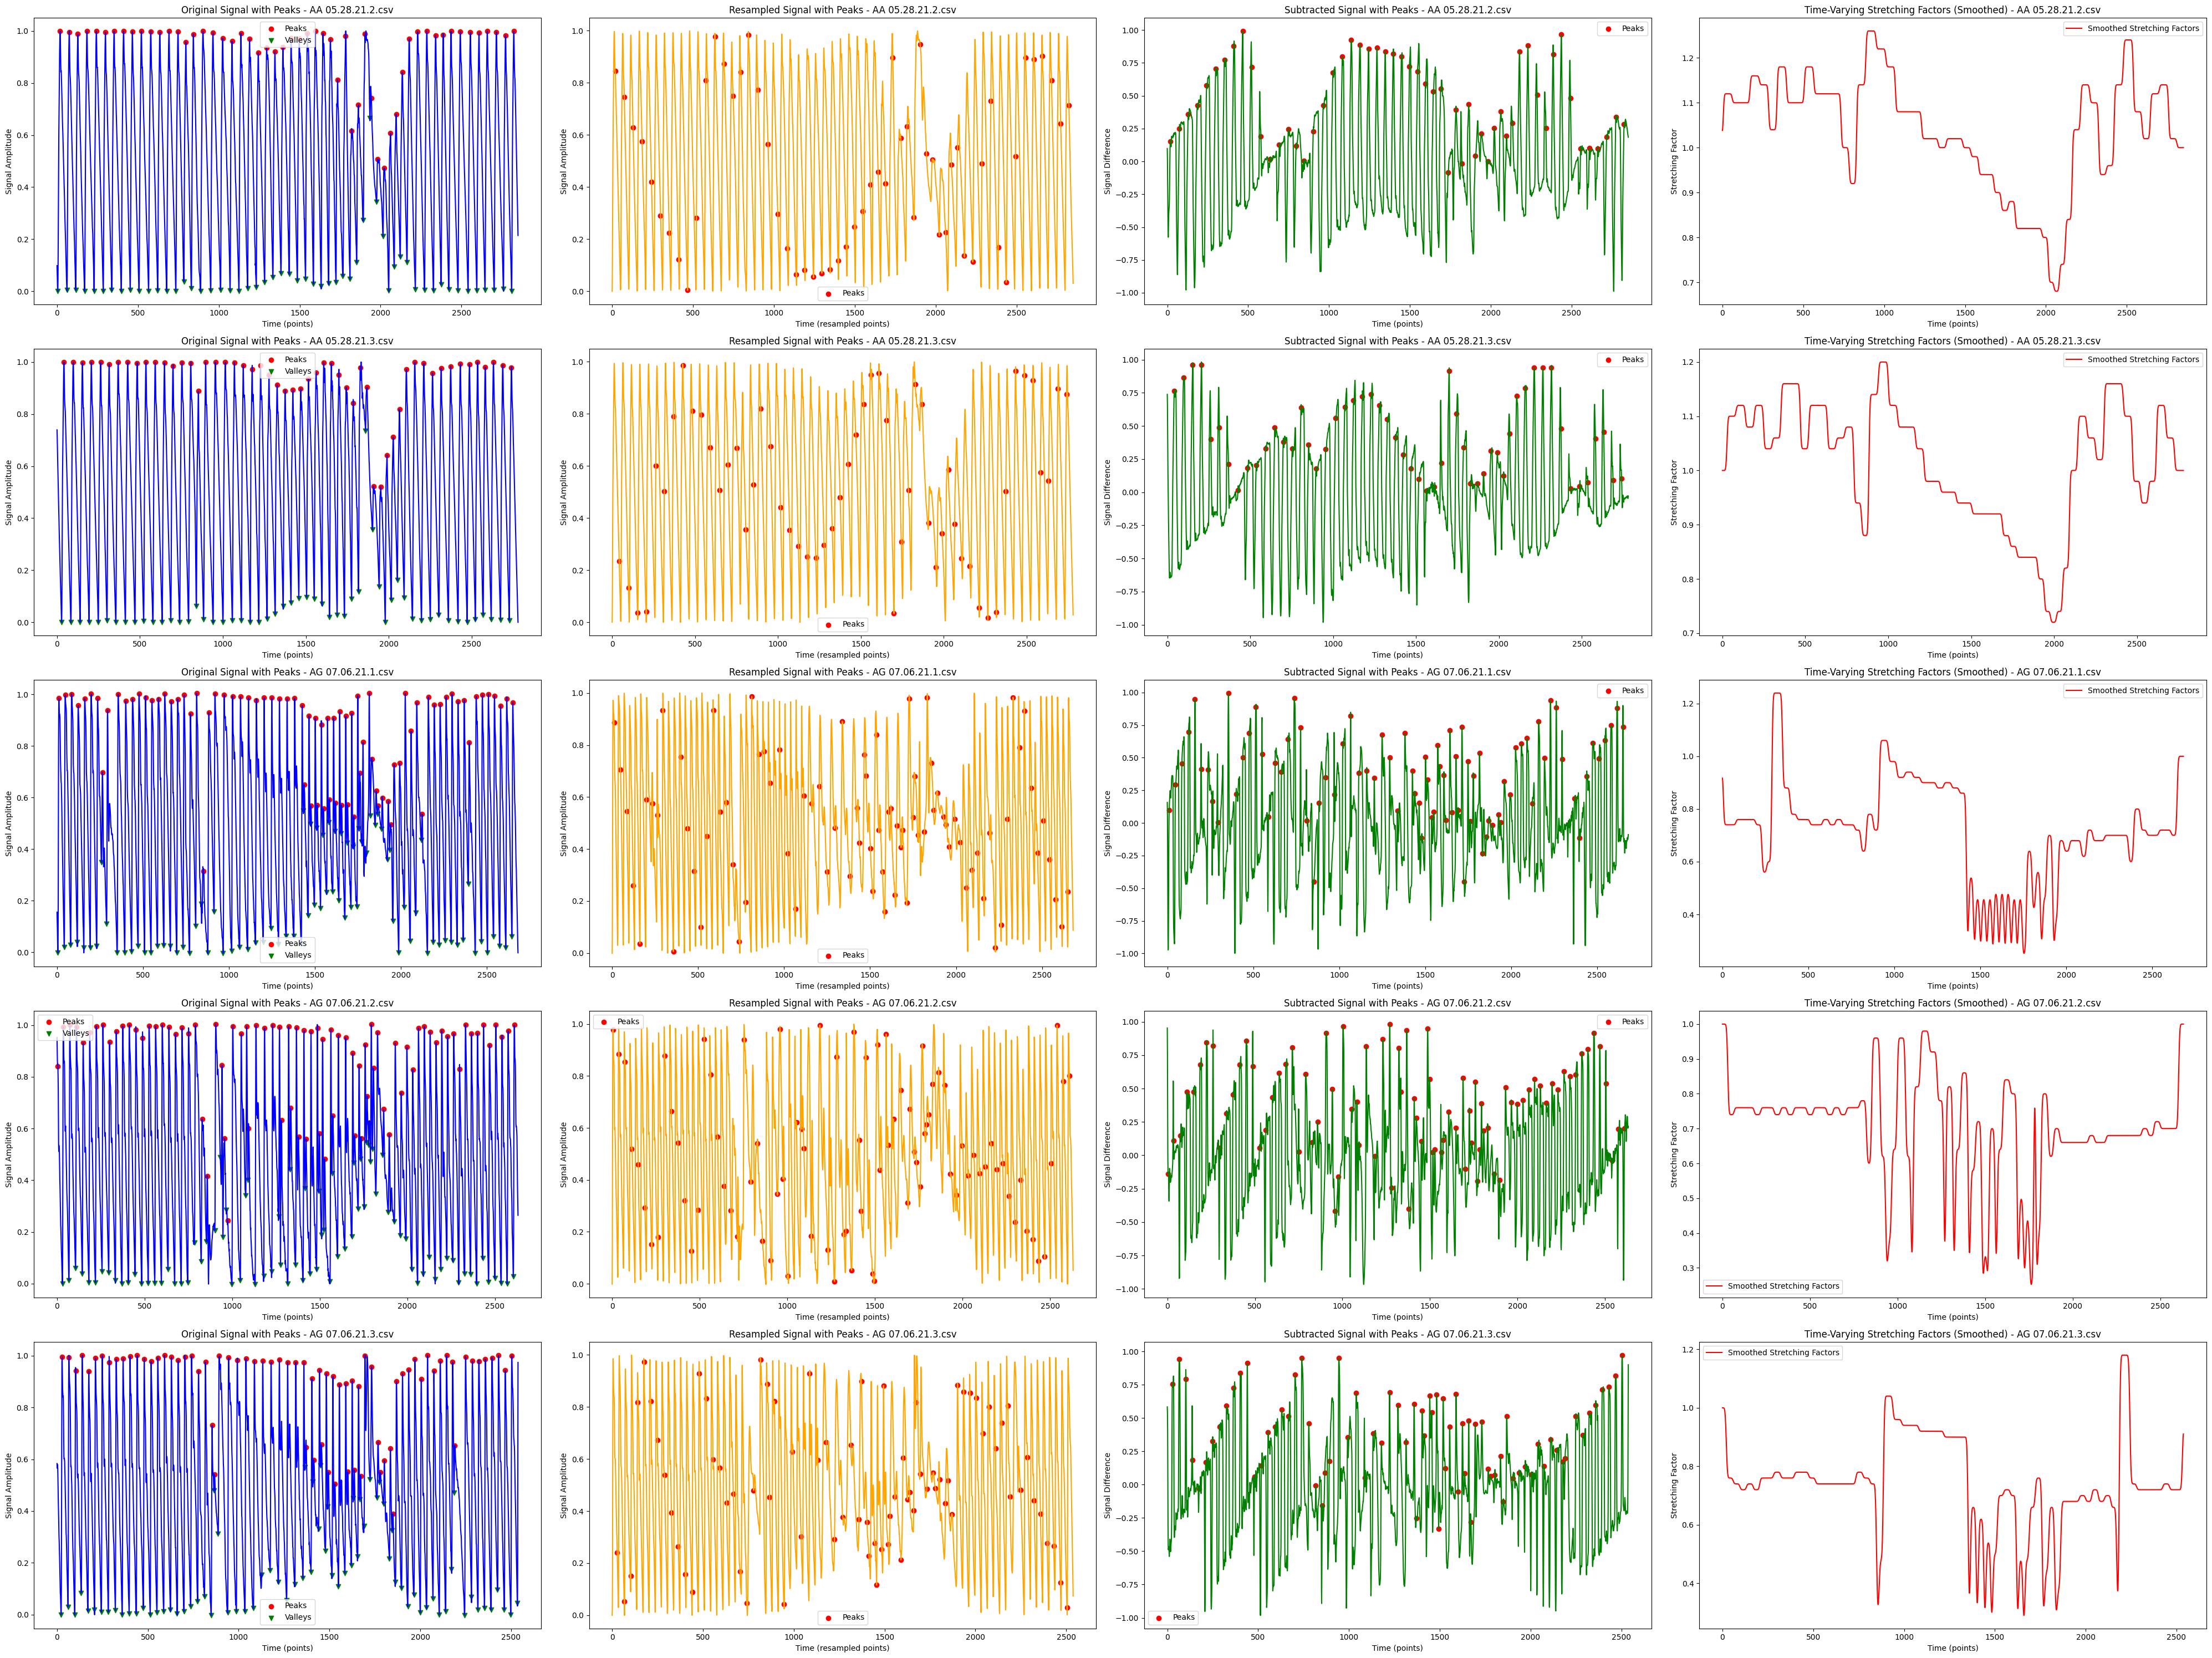

In [13]:
from scipy.ndimage import gaussian_filter1d
num_files_to_visualize = 5
fig, axes = plt.subplots(num_files_to_visualize, 4, figsize=(40, 6 * num_files_to_visualize))

for idx, filename in enumerate(selected_filenames[:num_files_to_visualize]):
    if (filename not in stretched_signals or
        filename not in stretching_factors or
        filename not in subtracted_signals or
        filename not in time_varying_stretching_factors or
        filename not in peak_indices):
        print(f"Warning: {filename} not processed.")
        continue

    # Original and resampled signals
    original_signal = ppg_signals_df[filename]['env_scaled'].values
    resampled_signal = stretched_signals[filename]
    subtracted_signal = subtracted_signals[filename]
    factors = stretching_factors[filename]
    time_varying_factors = time_varying_stretching_factors[filename]

    smoothed_factors = gaussian_filter1d(time_varying_factors, sigma=5)

    # Get peak and valley indices
    peaks = peak_indices[filename]['peaks']
    valleys = peak_indices[filename]['valleys']

    # Plot original signal with peak indicators
    axes[idx, 0].plot(original_signal, color='blue')
    axes[idx, 0].scatter(peaks, original_signal[peaks], color='red', marker='o', label='Peaks')
    axes[idx, 0].scatter(valleys, original_signal[valleys], color='green', marker='v', label='Valleys')
    axes[idx, 0].set_title(f"Original Signal with Peaks - {filename}")
    axes[idx, 0].set_xlabel("Time (points)")
    axes[idx, 0].set_ylabel("Signal Amplitude")
    axes[idx, 0].legend()

    # Plot resampled signal with peak indicators
    axes[idx, 1].plot(resampled_signal, color='orange')
    axes[idx, 1].scatter(peaks, resampled_signal[peaks], color='red', marker='o', label='Peaks')
    axes[idx, 1].set_title(f"Resampled Signal with Peaks - {filename}")
    axes[idx, 1].set_xlabel("Time (resampled points)")
    axes[idx, 1].set_ylabel("Signal Amplitude")
    axes[idx, 1].legend()

    # Plot subtracted signal with peak indicators
    axes[idx, 2].plot(subtracted_signal, color='green')
    axes[idx, 2].scatter(peaks, subtracted_signal[peaks], color='red', marker='o', label='Peaks')
    axes[idx, 2].set_title(f"Subtracted Signal with Peaks - {filename}")
    axes[idx, 2].set_xlabel("Time (points)")
    axes[idx, 2].set_ylabel("Signal Difference")
    axes[idx, 2].legend()

    # Plot time-varying stretching factors
    axes[idx, 3].plot(smoothed_factors, color='red', label='Smoothed Stretching Factors')
    axes[idx, 3].set_title(f"Time-Varying Stretching Factors (Smoothed) - {filename}")
    axes[idx, 3].set_xlabel("Time (points)")
    axes[idx, 3].set_ylabel("Stretching Factor")
    axes[idx, 3].legend()

plt.tight_layout()
plt.show()

## Plotly

In [15]:
import plotly.graph_objects as go
from dash import Dash, dcc, html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output

# Initialize Dash app
app = Dash(__name__, external_stylesheets=[dbc.themes.DARKLY])
app.title = "PPG Signal Analysis"

# App layout
def create_layout():
    return html.Div([
        dbc.NavbarSimple(
            children=[
                dbc.NavLink("Original Signal", href="/original", active="exact"),
                dbc.NavLink("Resampled Signal", href="/resampled", active="exact"),
                dbc.NavLink("Subtracted Signal", href="/subtracted", active="exact"),
                dbc.NavLink("Stretching Factors", href="/factors", active="exact"),
            ],
            brand="PPG Signal Analysis Dashboard",
            brand_href="/",
            color="primary",
            dark=True,
            style={"padding": "10px 20px"},
        ),

        html.Div([
            dbc.Row(
                dbc.Col([
                    html.Label("Select Patient Files:", className="text-light", style={"margin-bottom": "10px"}),
                    dcc.Dropdown(
                        id="file-dropdown",
                        options=[{"label": filename, "value": filename} for filename in selected_filenames],
                        value=[selected_filenames[0]],
                        placeholder="Select one or more files",
                        style={"width": "100%"},
                        multi=True
                    ),
                ], width={"size": 6, "offset": 3}, style={"margin-top": "20px"}),
            ),

            html.Hr(),

            dcc.Location(id="url"),
            html.Div(id="page-content", style={"padding": "20px"})
        ])
    ])

app.layout = create_layout

# Page content callbacks
@app.callback(
    Output("page-content", "children"),
    [Input("url", "pathname"), Input("file-dropdown", "value")]
)
def display_page(pathname, selected_files):
    if not selected_files:
        return html.Div("Please select at least one file.", style={"text-align": "center", "color": "red"})

    if pathname == "/original":
        return [generate_original_signal_plot(file) for file in selected_files]
    elif pathname == "/resampled":
        return [generate_resampled_signal_plot(file) for file in selected_files]
    elif pathname == "/subtracted":
        return [generate_subtracted_signal_plot(file) for file in selected_files]
    elif pathname == "/factors":
        return [generate_stretching_factors_plot(file) for file in selected_files]
    else:
        return html.H3("Welcome to the PPG Signal Analysis Dashboard! Use the navigation bar to view specific plots.", style={"text-align": "center", "color": "white"})

# Plot generation functions
def generate_original_signal_plot(selected_file):
    if selected_file not in peak_indices:
        return html.Div(f"Data not available for the selected file: {selected_file}.", style={"text-align": "center", "color": "red"})

    original_signal = ppg_signals_df[selected_file]['env_scaled'].values
    peaks = peak_indices[selected_file]['peaks']
    valleys = peak_indices[selected_file]['valleys']

    fig = go.Figure()
    fig.add_trace(go.Scatter(y=original_signal, mode='lines', name="Original Signal", line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=peaks, y=original_signal[peaks], mode='markers', name='Peaks', marker=dict(color='red', symbol='circle')))
    fig.add_trace(go.Scatter(x=valleys, y=original_signal[valleys], mode='markers', name='Valleys', marker=dict(color='green', symbol='triangle-down')))

    fig.update_layout(
        title=f"Original Signal with Peaks for {selected_file}",
        template="plotly_dark",
        height=600,
        margin=dict(l=20, r=20, t=50, b=20)
    )

    return html.Div([dcc.Graph(figure=fig)], style={"margin-bottom": "20px"})

# Similarly update other plotting functions (resampled, subtracted, factors) to handle each selected file.
def generate_resampled_signal_plot(selected_file):
    if selected_file not in stretched_signals:
        return html.Div("Data not available for the selected file.", style={"text-align": "center"})

    resampled_signal = stretched_signals[selected_file]
    #peaks = peak_indices[selected_file]['peaks']

    fig = go.Figure()
    fig.add_trace(go.Scatter(y=resampled_signal, mode='lines', name="Resampled Signal", line=dict(color='orange')))
    #fig.add_trace(go.Scatter(x=peaks, y=resampled_signal[peaks], mode='markers', name='Peaks', marker=dict(color='red', symbol='circle')))

    fig.update_layout(
        title=f"Resampled Signal with Peaks for {selected_file}",
        template="plotly_dark",
        height=600,
        margin=dict(l=20, r=20, t=50, b=20)
    )

    return dcc.Graph(figure=fig)

def generate_subtracted_signal_plot(selected_file):
    if selected_file not in subtracted_signals:
        return html.Div("Data not available for the selected file.", style={"text-align": "center"})

    subtracted_signal = subtracted_signals[selected_file]
    #peaks = peak_indices[selected_file]['peaks']

    fig = go.Figure()
    fig.add_trace(go.Scatter(y=subtracted_signal, mode='lines', name="Subtracted Signal", line=dict(color='green')))
    #fig.add_trace(go.Scatter(x=peaks, y=subtracted_signal[peaks], mode='markers', name='Peaks', marker=dict(color='red', symbol='circle')))

    fig.update_layout(
        title=f"Subtracted Signal for {selected_file}",
        template="plotly_dark",
        height=600,
        margin=dict(l=20, r=20, t=50, b=20)
    )

    return dcc.Graph(figure=fig)

def generate_stretching_factors_plot(selected_file):
    if selected_file not in time_varying_stretching_factors:
        return html.Div("Data not available for the selected file.", style={"text-align": "center", "color": "red"})

    time_varying_factors = time_varying_stretching_factors[selected_file]
    smoothed_factors = gaussian_filter1d(time_varying_factors, sigma=5)

    fig = go.Figure()
    #fig.add_trace(go.Scatter(y=time_varying_factors, mode='lines', name="Original Factors", line=dict(color='red')))
    fig.add_trace(go.Scatter(y=smoothed_factors, mode='lines', name="Smoothed Factors", line=dict(color='red')))

    fig.update_layout(
        title=f"Time-Varying Stretching Factors for {selected_file}",
        template="plotly_dark",
        height=600,
        margin=dict(l=20, r=20, t=50, b=20),
        xaxis_title="Time (points)",
        yaxis_title="Stretching Factor"
    )

    return dcc.Graph(figure=fig)


# Run the app
if __name__ == "__main__":
    app.run_server(debug=True)


<IPython.core.display.Javascript object>